In [149]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [150]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [151]:
len(words)

32033

In [152]:
chars=sorted(list(set("".join(words))))
stoi={s:i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}

In [153]:
#Build the dataser
block_size=3
X,Y=[],[]
for w in words:
    context=[0]*block_size
    for ch in w +'.':
        ix=stoi[ch]
        X.append(context)
        Y.append(ix)
        context=context[1:]+[ix]
X=torch.tensor(X)
Y=torch.tensor(Y)

In [154]:
X.shape,X.dtype,Y.shape,Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [155]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [170]:
g=torch.Generator().manual_seed(2147483647)
C=torch.randn((27,10),generator=g)
W1=torch.randn((30,300),generator=g)
b1=torch.randn(300,generator=g)
W2=torch.randn((300,27),generator=g)
b2=torch.randn(27,generator=g)
parameters=[C,W1,b1,W2,b2]


In [171]:
sum(p.nelement() for p in parameters)

17697

In [172]:
for p in parameters:
    p.requires_grad=True

In [173]:
lre=torch.linspace(-3,0,1000)
lrs=10**lre

In [187]:
lri=[]
lossi=[]
step= []

In [196]:
for i in range(30000):
    #miniset
    ix=torch.randint(0,Xtr.shape[0],(32,))
    #forward pass
    emb=C[Xtr[ix]]
    h=torch.tanh((emb.view(-1,30) @ W1) + b1)
    logits=h @ W2 + b2
    loss=F.cross_entropy(logits,Ytr[ix])
    #backward pass
    for p in parameters:
        p.grad=None
    loss.backward()
    #update
    lr=0.005
    for p in parameters:
        p.data+=-lr*p.grad
    # #track stats
    lri.append(lr)
    lossi.append(loss.log10().item())
    step.append(i)


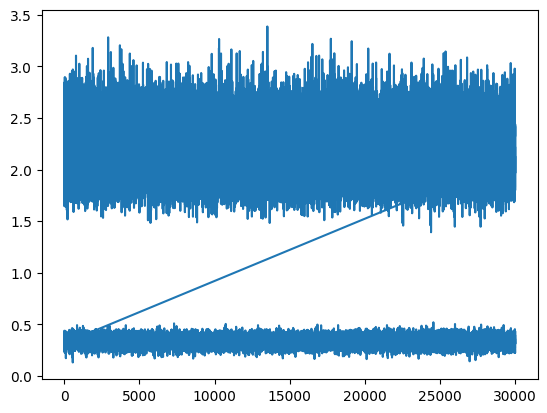

In [197]:
plt.plot(step,lossi)

In [198]:
emb=C[Xtr]
h=torch.tanh((emb.view(-1,30) @ W1) + b1)
logits=h @ W2 + b2
loss=F.cross_entropy(logits,Ytr)
loss.item()

2.184048652648926

In [199]:
emb=C[Xdev]
h=torch.tanh((emb.view(-1,30) @ W1) + b1)
logits=h @ W2 + b2
loss=F.cross_entropy(logits,Ydev)
loss.item()

2.2094593048095703

In [148]:
# training split / cross validation or dev split / test split
# 80% / 10% / 10%
